## **MULTI-LAYER COUPLED TRANSMONS**
---

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

### Import Qiskit Metal GUI and QComponents

In [2]:
from qiskit_metal import designs, MetalGUI
from qiskit_metal.qlibrary.sample_shapes.rectangle import Rectangle
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

### Define QDesign with its corresponding layer stack

In [3]:
design = designs.MultiPlanar({}, overwrite_enabled=True, layer_stack_filename="layer_stack.txt")
design.variables.sample_holder_top = '320 um'
design.variables.sample_holder_bottom ='250 um'
gui = MetalGUI(design)

#### Layer Stack

In [4]:
design.ls.ls_df

,chip_name,layer,datatype,material,thickness,z_coord,fill
0,'main',1,0,'pec','5um','0um','True'
1,'main',2,0,'pec','50um','5um','True'
2,'main',3,0,'pec','5um','55um','True'
3,'main',4,0,'silicon','-200um','0um','True'
4,'main',5,0,'silicon','50um','5um','True'


<img src="layer_stack.png" width = 600 align = "left"/>

### Draw Transmons in Layer 1

In [5]:
design.delete_all_components()
# Define a dictionary for connection pad options for the transmon
conn_pads1 = dict(connection_pads = dict(coupler = dict(loc_W=1, loc_H=1),
                                         readout = dict(loc_W=-1, loc_H=-1)))
conn_pads2 = dict(pad_width = '550 um', 
                  pad_gap = '15um', 
                  connection_pads = dict(coupler = dict(loc_W=-1, loc_H=1,pad_width='275um', pad_cpw_shift = '12.5um'),
                                         readout = dict(loc_W=1, loc_H=-1,pad_width='275um')))

# Create a TransmonPocket6 object
q1 = TransmonPocket(design, "Q1", options=dict(pos_x='-0.5mm', pos_y='+0.0mm', layer=1, **conn_pads1))
q2 = TransmonPocket(design, "Q2", options=dict(pos_x='+0.5mm', pos_y='+0.0mm', layer=1, **conn_pads2))

# Rebuild and autoscale the GUI
gui.rebuild()
gui.autoscale()

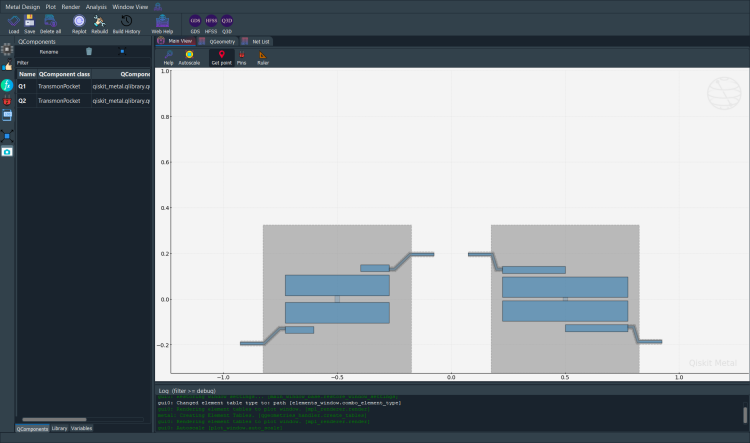

In [6]:
gui.screenshot()

In [7]:
# Connect Transmons with direct coupler
coupler_options = dict(pin_inputs = dict(start_pin=dict(component=q2.name, pin='coupler'),
                                         end_pin=dict(component=q1.name, pin='coupler')))

coupler_connector = RouteStraight(design, 'coupler_connector', options= coupler_options)

# Rebuild and autoscale the GUI
gui.rebuild()
gui.autoscale()

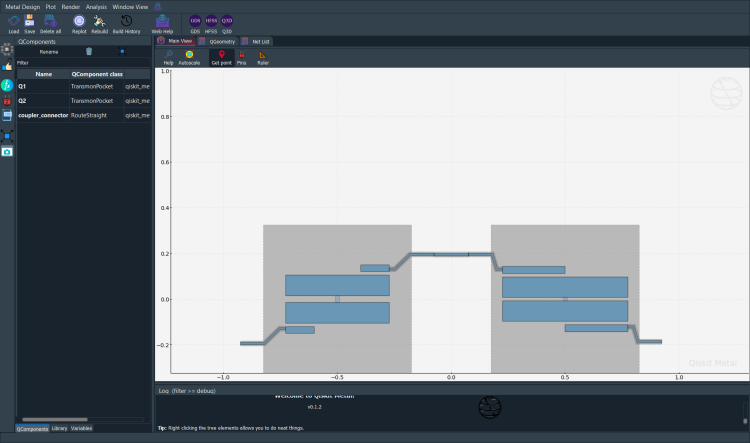

In [8]:
gui.screenshot()

### Draw Readout Resonators in Layer 3

In [9]:
# Create open-to-ground elements for readout resonators
otg11_options = dict(pos_x='-1.5mm',  pos_y='0.0mm', orientation='180', layer='3')
otg21_options = dict(pos_x='+1.5mm',  pos_y='0.0mm', orientation='0', layer='3')
otg12_options = dict(pos_x='-0.955mm',  pos_y='-0.195mm', orientation='0', layer='3')
otg22_options = dict(pos_x='+0.955mm',  pos_y='-0.1875mm', orientation='180', layer='3')
otg11 = OpenToGround(design, 'otg11', options=otg11_options)
otg21 = OpenToGround(design, 'otg21', options=otg21_options)
otg12 = OpenToGround(design, 'otg12', options=otg12_options)
otg22 = OpenToGround(design, 'otg22', options=otg22_options)


# Create readout resonators
readout1_options = dict(total_length = '5.97mm',
                       fillet = '40um',
                       pin_inputs = dict(start_pin = dict(component = otg11.name, pin = 'open'),
                                         end_pin = dict(component = otg12.name, pin = 'open')),
                       lead=dict(start_straight='150um'),
                       meander=dict(spacing = '100um', asymmetry = '0'),
                       layer = '3')

readout2_options = dict(total_length = '5.97mm',
                       fillet = '40um',
                       pin_inputs = dict(start_pin = dict(component = otg22.name, pin = 'open'),
                                         end_pin = dict(component = otg21.name, pin = 'open')),
                       lead=dict(start_straight='120um'),
                       meander=dict(spacing = '100um', asymmetry = '0.2'),
                       layer = '3')

readout1 = RouteMeander(design, 'readout1', options=readout1_options)
readout2 = RouteMeander(design, 'readout2', options=readout2_options)

# Rebuild and autoscale the GUI
gui.rebuild()
gui.autoscale()

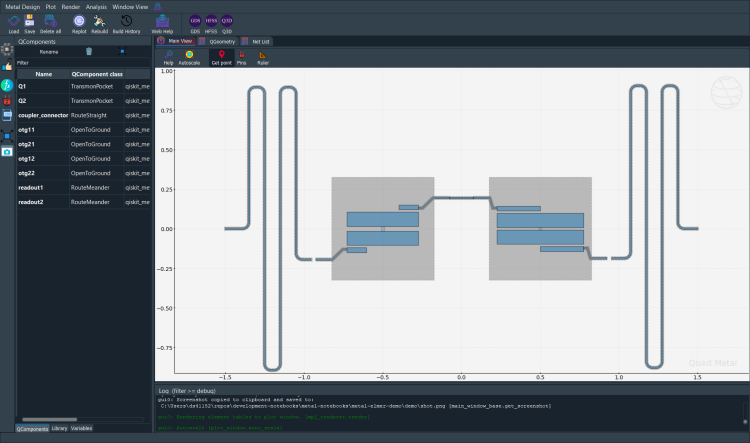

In [10]:
gui.screenshot()

### Define Vias in Layers 1-2-3 & Dielectric in Layer 5

In [11]:
# Create via components
via_positions = [('-0.94mm','-0.1950mm'),('+0.94mm','-0.1875mm')]

for layer in ['1','2','3']:
    for via, positions in enumerate(via_positions):
        for subtract in zip([False,True],['30um','42um']):
            via_size = '20um' if layer == '2' else subtract[1]
            actual_layer = '5' if (layer == '2' and subtract[0]) else layer
            via_options = dict(width = via_size,
                               height = via_size,
                               pos_x = positions[0],
                               pos_y = positions[1],
                               subtract = subtract[0],
                               layer = actual_layer,
                               orientation = '0',
                               helper = 'False',
                               chip = 'main')

            name = 'via'+str(via+1)+'_layer'+actual_layer+('' if not subtract[0] else '_sub')
            Rectangle(design, name, via_options)

# Rebuild and autoscale the GUI
gui.rebuild()
gui.autoscale()

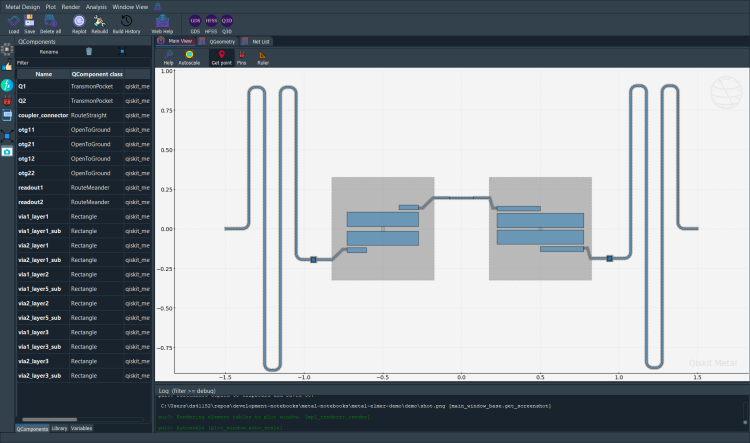

In [12]:
gui.screenshot()

### Render/Mesh 3D Design Using gmsh

In [13]:
from qiskit_metal.renderers.renderer_elmer.elmer_renderer import QElmerRenderer

In [14]:
elmer_renderer = QElmerRenderer(design, layer_types=dict(metal=[1,2,3], dielectric=[4,5]))
elmer_renderer.render_design(mesh_geoms=True, 
                             skip_junctions=True,
                             open_pins=[("Q1", "readout"),("Q2", "readout")],
                             omit_ground_for_layers=[2])

In [15]:
#elmer_renderer.launch_gmsh_gui()

### Export Mesh, Initialize ElmerFEM and Solve

In [16]:
elmer_renderer.export_mesh()
elmer_renderer.add_solution_setup('capacitance')
elmer_renderer.run('capacitance')

11:54AM 36s INFO [run]: Running ElmerGrid on input mesh from Gmsh...
11:54AM 43s INFO [run]: Running ElmerSolver for solver type: 'capacitance'


### Extract Capacitance Matrix and Display Solver Results

In [17]:
# Display capacitance matrix in [fF]
cap_matrix = elmer_renderer.capacitance_matrix
cap_matrix

,Q2_coupler_wire,via2_layer3_rectangle,readout1_trace,Q2_pad_bot,Q2_pad_top,Q1_pad_top,Q1_pad_bot,ground_plane
Q2_coupler_wire,351.783551,-0.296194,-0.081738,-2.979679,-45.345447,-23.832560,-1.803088,-277.444845
via2_layer3_rectangle,-0.296194,1754.301112,-0.000292,-45.554015,-2.960783,-0.004068,-0.006141,-1705.479620
readout1_trace,-0.081738,-0.000292,1710.577917,-0.003279,-0.002187,-1.762725,-23.848437,-1684.879260
Q2_pad_bot,-2.979679,-45.554015,-0.003279,318.180144,-90.710881,-0.054492,-0.075602,-178.802196
Q2_pad_top,-45.345447,-2.960783,-0.002187,-90.710881,318.360444,-0.049137,-0.053949,-179.238060
Q1_pad_top,-23.832560,-0.004068,-1.762725,-0.054492,-0.049137,239.427316,-51.895314,-161.829020
Q1_pad_bot,-1.803088,-0.006141,-23.848437,-0.075602,-0.053949,-51.895314,239.392544,-161.710013
ground_plane,-277.444845,-1705.479620,-1684.879260,-178.802196,-179.238060,-161.829020,-161.710013,300.000000


In [18]:
elmer_renderer.display_post_processing_data()
elmer_renderer.close()

11:56AM 55s INFO [model]: Added new model '_post_processing' and set as current.


### Simulating Individual Transmons

#### Q1 Transmon

In [19]:
# Mesh Q1-only design
elmer_renderer = QElmerRenderer(design, layer_types=dict(metal=[1,2,3], dielectric=[4,5]))
select = ['Q1', 'via1_layer1', 'via1_layer2', 'via1_layer3',
          'via1_layer1_sub', 'via1_layer5_sub', 'via1_layer3_sub']

elmer_renderer.render_design(selection=select,
                             open_pins=[('Q1', 'coupler'), ('Q1', 'readout')],
                             skip_junctions=True,
                             omit_ground_for_layers=[2])

elmer_renderer.launch_gmsh_gui()

In [20]:
# Solve Q1-only mode and save Cap Matrix
elmer_renderer.export_mesh()
elmer_renderer.add_solution_setup('capacitance')
elmer_renderer.run('capacitance')
cap_matrix_q1 = elmer_renderer.capacitance_matrix
#elmer_renderer.close()
cap_matrix_q1

11:58AM 09s INFO [run]: Running ElmerGrid on input mesh from Gmsh...
11:58AM 11s INFO [run]: Running ElmerSolver for solver type: 'capacitance'


,Q1_coupler_connector_pad,via1_layer3_rectangle,Q1_pad_top,Q1_pad_bot,ground_plane
Q1_coupler_connector_pad,122.913446,-0.082913,-23.777451,-1.761381,-97.291701
via1_layer3_rectangle,-0.082913,174.229841,-1.792283,-23.915161,-148.439484
Q1_pad_top,-23.777451,-1.792283,239.289127,-51.894792,-161.824602
Q1_pad_bot,-1.761381,-23.915161,-51.894792,239.060992,-161.489658
ground_plane,-97.291701,-148.439484,-161.824602,-161.489658,300.000000


In [21]:
elmer_renderer.display_post_processing_data()
elmer_renderer.close()

11:58AM 41s INFO [model]: Added new model '_post_processing' and set as current.


#### Q2 Transmon

In [22]:
# Mesh Q2-only design
elmer_renderer = QElmerRenderer(design, layer_types=dict(metal=[1,2,3], dielectric=[4,5]))
select = ['Q2', 'via2_layer1', 'via2_layer2', 'via2_layer3',
          'via2_layer1_sub', 'via2_layer5_sub', 'via2_layer3_sub']
elmer_renderer.render_design(selection=select,
                             open_pins=[('Q2', 'coupler'), ('Q2', 'readout')],
                             skip_junctions=True, omit_ground_for_layers=[2])
#elmer_renderer.launch_gmsh_gui()

In [23]:
# Solve Q2-only mode and save Cap Matrix
elmer_renderer.export_mesh()
elmer_renderer.add_solution_setup('capacitance')
elmer_renderer.run('capacitance')
cap_matrix_q2 = elmer_renderer.capacitance_matrix
elmer_renderer.close()
cap_matrix_q2

11:59AM 09s INFO [run]: Running ElmerGrid on input mesh from Gmsh...
11:59AM 11s INFO [run]: Running ElmerSolver for solver type: 'capacitance'


,Q2_coupler_connector_pad,via2_layer3_rectangle,Q2_pad_top,Q2_pad_bot,ground_plane
Q2_coupler_connector_pad,169.038156,-0.296328,-45.250993,-2.933859,-120.556976
via2_layer3_rectangle,-0.296328,221.471147,-2.958499,-45.657385,-172.558934
Q2_pad_top,-45.250993,-2.958499,318.173117,-90.960776,-179.002849
Q2_pad_bot,-2.933859,-45.657385,-90.960776,318.661404,-179.109384
ground_plane,-120.556976,-172.558934,-179.002849,-179.109384,300.000000


### LOM Analysis
for details regarding the code below, see notebook: `4.05 New LOM and Two Coupled Transmon Example.ipynb` under 

`qiskit-metal/tutorials/4 Analysis/A. Core - EM and quantization/`

In [24]:
%matplotlib inline
import scqubits as scq
from scipy.constants import speed_of_light as c_light
import matplotlib.pyplot as plt

from qiskit_metal.analyses.quantization.lumped_capacitive import load_q3d_capacitance_matrix
from qiskit_metal.analyses.quantization.lom_core_analysis import CompositeSystem, Cell, Subsystem, QuantumSystemRegistry

11:59AM 41s INFO [__init__]: TransmonBuilder with system_type TRANSMON registered to QuantumSystemRegistry
11:59AM 41s INFO [__init__]: FluxoniumBuilder with system_type FLUXONIUM registered to QuantumSystemRegistry
11:59AM 41s INFO [__init__]: TLResonatorBuilder with system_type TL_RESONATOR registered to QuantumSystemRegistry
11:59AM 41s INFO [__init__]: LumpedResonatorBuilder with system_type LUMPED_RESONATOR registered to QuantumSystemRegistry


#### Create LOM cells from capacitance matrices

In [25]:
# cell 1: 1st transmon (Q1)
opt1 = dict(node_rename = {'Q1_coupler_connector_pad': 'coupling', 'via1_layer3_rectangle': 'readout_1'}, 
            cap_mat = cap_matrix_q1,
            ind_dict = {('Q1_pad_top', 'Q1_pad_bot'):10},  # junction inductance in nH
            jj_dict = {('Q1_pad_top', 'Q1_pad_bot'):'j1'},
            cj_dict = {('Q1_pad_top', 'Q1_pad_bot'):2} # junction capacitance in fF
           )
cell_1 = Cell(opt1)


# cell 2: 2nd transmon (Q2)
opt2 = dict(node_rename = {'Q2_coupler_connector_pad': 'coupling', 'via2_layer3_rectangle': 'readout_2'},
            cap_mat = cap_matrix_q2,
            ind_dict = {('Q2_pad_top', 'Q2_pad_bot'): 12}, # junction inductance in nH
            jj_dict = {('Q2_pad_top', 'Q2_pad_bot'):'j2'},
            cj_dict = {('Q2_pad_top', 'Q2_pad_bot'):2} # junction capacitance in fF
           )
cell_2 = Cell(opt2)

#### Create Subsystems

In [26]:
# subsystem 1: transmon 1
transmon_1 = Subsystem(name='transmon_1', sys_type='TRANSMON', nodes=['j1'])

# subsystem 2: transmon 2
transmon_2 = Subsystem(name='transmon_2', sys_type='TRANSMON', nodes=['j2'])

# subsystem 3: readout resonator 1
q_opts = dict(f_res = 8, # resonator dressed frequency in GHz
              Z0 = 50, # characteristic impedance in Ohm
              vp = 0.404314 * c_light # phase velocity 
              )
res_1 = Subsystem(name='readout_1', sys_type='TL_RESONATOR', nodes=['readout_1'], q_opts=q_opts)

# subsystem 4: readout resonator 2
q_opts = dict(f_res = 7.6, # resonator dressed frequency in GHz
              Z0 = 50, # characteristic impedance in Ohm
              vp = 0.404314 * c_light # phase velocity 
              )
res_2 = Subsystem(name='readout_2', sys_type='TL_RESONATOR', nodes=['readout_2'], q_opts=q_opts)

#### Create the composite system from the cells and the subsystems

In [27]:
composite_sys = CompositeSystem(subsystems=[transmon_1, transmon_2, res_1, res_2], 
                                cells=[cell_1, cell_2], 
                                grd_node='ground_plane',
                                nodes_force_keep=['readout_1', 'readout_2'])

cg = composite_sys.circuitGraph()
print(cg)

node_jj_basis:
-------------

['j1', 'Q1_pad_bot', 'j2', 'Q2_pad_bot', 'readout_1', 'readout_2', 'coupling']

nodes_keep:
-------------

['j1', 'j2', 'readout_1', 'readout_2']


L_inv_k (reduced inverse inductance matrix):
-------------

            j1        j2  readout_1  readout_2
j1         0.1  0.000000        0.0        0.0
j2         0.0  0.083333        0.0        0.0
readout_1  0.0  0.000000        0.0        0.0
readout_2  0.0  0.000000        0.0        0.0

C_k (reduced capacitance matrix):
-------------

                   j1          j2   readout_1   readout_2
j1         147.110468   -0.817358   10.998440   -0.210114
j2          -0.817358  205.114809   -0.136402   20.918712
readout_1   10.998440   -0.136402  172.453627   -0.035064
readout_2   -0.210114   20.918712   -0.035064  216.171619




#### Generate hilberspace from composite system (scqubits package)

In [28]:
hilbertspace = composite_sys.create_hilbertspace()
print(hilbertspace)

HilbertSpace:  subsystems
-------------------------

Transmon------------| [Transmon_1]
                    | EJ: 16346.15128067812
                    | EC: 132.30509715257884
                    | ng: 0.001
                    | ncut: 22
                    | truncated_dim: 10
                    |
                    | dim: 45


Transmon------------| [Transmon_2]
                    | EJ: 13621.792733898432
                    | EC: 95.37935897397644
                    | ng: 0.001
                    | ncut: 22
                    | truncated_dim: 10
                    |
                    | dim: 45


Oscillator----------| [Oscillator_1]
                    | E_osc: 8000
                    | l_osc: None
                    | truncated_dim: 3
                    |
                    | dim: 3


Oscillator----------| [Oscillator_2]
                    | E_osc: 7600.0
                    | l_osc: None
                    | truncated_dim: 3
                    |
                    

In [29]:
hilbertspace = composite_sys.add_interaction()
hilbertspace.hamiltonian()

Quantum object: dims = [[10, 10, 3, 3], [10, 10, 3, 3]], shape = (900, 900), type = oper, isherm = True
Qobj data =
[[-26334.05930637+0.j              0.        +0.08611877j
       0.        +0.j         ...      0.        +0.j
       0.        +0.j              0.        +0.j        ]
 [     0.        -0.08611877j -18734.05930637+0.j
       0.        +0.12179034j ...      0.        +0.j
       0.        +0.j              0.        +0.j        ]
 [     0.        +0.j              0.        -0.12179034j
  -11134.05930637+0.j         ...      0.        +0.j
       0.        +0.j              0.        +0.j        ]
 ...
 [     0.        +0.j              0.        +0.j
       0.        +0.j         ...  43360.74139059+0.j
       0.        +0.48987729j      0.        +0.j        ]
 [     0.        +0.j              0.        +0.j
       0.        +0.j         ...      0.        -0.48987729j
   50960.74139059+0.j              0.        +0.69279111j]
 [     0.        +0.j              0.   

#### Print results

In [30]:
hamiltonian_results = composite_sys.hamiltonian_results(hilbertspace, evals_count=30)


system frequencies in GHz:
--------------------------
{'transmon_1': 4.019675194169103, 'transmon_2': 3.120601430507195, 'readout_1': 8.001513163253206, 'readout_2': 7.602007952444495}

Chi matrices in MHz
--------------------------
            transmon_1  transmon_2     readout_1     readout_2
transmon_1 -143.059158   -0.040725 -2.774480e-01 -6.378080e-05
transmon_2   -0.040725 -102.275071 -1.901543e-05 -3.127685e-01
readout_1    -0.277448   -0.000019 -3.982115e+03  7.703602e-08
readout_2    -0.000064   -0.312769  7.703602e-08  4.304429e+00


In [31]:
composite_sys.compute_gs()

                  j1         j2  readout_1  readout_2
j1          0.000000   4.109628 -68.842169   0.729457
j2          4.109628   0.000000   0.332902 -86.848229
readout_1 -68.842169   0.332902   0.000000   0.059090
readout_2   0.729457 -86.848229   0.059090   0.000000